# Final Report: Predicting Heart Disease

**Group 11**

## Introduction

Heart disease is one of the leading causes of death for people of most racial and ethnic groups in the world<sup>4,11</sup>. It refers to any condition that affects the structure or function of the heart. The most common type is coronary heart disease, caused by narrowing of arteries and leads to heart attacks and chest pains (anginas)<sup>5,11</sup>. Thus, prevention and accurate prediction of heart disease is a crucial scientific topic. In this project, we will answer the question: **How accurately can we predict whether an individual suffers from heart disease or not given related health indicators?**

With the prevalence of machine learning, it is gradually being applied to many industries, including healthcare, for disease prediction and diagnosis.<sup>1,7</sup>. Current literature has demonstrated two contradicting results in heart disease prediction models. Some research shows that random forest and K-nearest neighbors produce the greatest accuracy<sup>2,6,7,10</sup> in contrast to the findings that multinomial logistic regression model outperforms other hybrid models<sup>9</sup>. Generally, logistic regression is not very popular, perhaps for its  lower accuracy levels in comparison to other models. Despite the contradicting results from research on logistic regression, this does not necessarily suggest that it is a bad choice. Thus, our main purpose was to seek to improve the accuracy of prediction of heart disease using logistic regression and minimize the amount of diagnostic errors to provide a better quality health case service to patients<sup>1</sup>.

The data set we used to answer our question is found in the UCI Machine Learning Repository Heart Disease Data Set<sup>8</sup>. This dataset contains a diagnosis of heart disease for each patient (`num`), some descriptive variables (eg. age), and numerous categorical (eg. `cp`) and continuous (eg. `chol`) bodily measurements related to the heart.  All the variables are in Table 1 of Appendix I. 

## Methods and Results 

### **Preliminary Results** 

In [19]:
library(tidyverse)
library(GGally)
library(gridExtra)
library(cowplot)
library(shiny)
library(tidymodels)
library(glmnet)
library(leaps)

# Setting plot formats as PNG instead of SVG in order to render properly. Otherwise, outputs are too large to render within standard HTML files
# options(jupyter.plot_mimetypes = "image/svg+xml") 
options(jupyter.plot_mimetypes = "image/png") 

# Sourcing all external functions created
source("logistic_stepforward.r")
source("conf_mat_logistic.r")
source("log_model_spec.r")

We first read the data (replacing all "?" with NA since the predetermined NA value was "?", and NA is easier to deal with). Then, we added a new column `country` which will help keep track of which hospital the data came from. Specifically, `0` = United States, `1` = Switzerland, and `2` = Hungary.

In [2]:
# Setting names of columns
names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num", show_col_types = FALSE)

# Reading all of the data from https://archive.ics.uci.edu/ml/datasets/heart+Disease
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = names, na = "?", show_col_types = FALSE) %>% mutate(country = 0)
switzerland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data", col_names = names, na = "?", show_col_types = FALSE) %>% mutate(country = 1)
hungary_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data", col_names = names, na = "?", show_col_types = FALSE) %>% mutate(country = 2)
va_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data", col_names = names, na = "?", show_col_types = FALSE) %>% mutate(country = 0)

The counts of NA values in each dataset, and within every column was produced, which allows us to see which columns we should remove early on, and which would likely cause issues (i.e. missing data).

In [3]:
NA_counts <- as.data.frame(cleveland_data[FALSE, ])
x <- substitute(list(cleveland_data, switzerland_data, hungary_data, va_data))

for (i in as.list(x)[-1]) {
    NA_counts[nrow(NA_counts) + 1,] <- map_df(get(i), ~sum(is.na(.x)))
    rownames(NA_counts)[nrow(NA_counts)] <- deparse(i)
}

strong("Table 1: Number of NA values in each column, of each dataset")
NA_counts

Shiny tags cannot be represented in plain text (need html)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,country
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cleveland_data,0,0,0,0,0,0,0,0,0,0,0,4,2,0,0
switzerland_data,0,0,0,2,0,75,1,1,1,6,17,118,52,0,0
hungary_data,0,0,0,1,23,8,1,1,1,0,190,291,266,0,0
va_data,0,0,0,56,7,7,0,53,53,56,102,198,166,0,0


The columns `slope`, `ca`, and `thal` all have a large quantity of NA values within three of the four datasets. For this reason, we chose to drop these three columns because performing imputation with such a small quantity of usable data will lead to inaccurate results, and choosing to omit NA values will delete the rows entirely, making us lose a large number of rows. Additionally, we chose to drop `fbs`, `exang`, and `oldpeak` for a similar reason. Thus, removing these columns will allow us to keep more observations for our analysis and simplify our model later on by exchanging less features for more data.

In [4]:
data_tidy_multi <- rbind(cleveland_data, switzerland_data, hungary_data, va_data) %>%
    select(-slope, -ca, -thal, -fbs, -exang, -oldpeak) %>%
    na.omit()

num_counts_multi <- data_tidy_multi %>%
    group_by(num) %>%
    summarize(counts = n(), proportions = counts/nrow(data_tidy_multi))

strong("Table 2: Number of observations in each of the target classes")
num_counts_multi

Shiny tags cannot be represented in plain text (need html)

num,counts,proportions
<dbl>,<int>,<dbl>
0,373,0.44831731
1,244,0.29326923
2,100,0.12019231
3,91,0.10937500
4,24,0.02884615


We see that there is a large class imbalance within the dataset, particularly for more severe heart disease. Since our analysis is focused on finding whether patients have heart disease or not, we are not interested in the severity of their condition. Therefore, we can binarize the output variable by grouping categories 1-4 into a single case (has heart disease).

In [5]:
data_tidy <- data_tidy_multi %>%
    mutate(num = ifelse(num == 0, 0, 1)) %>%
    mutate(num = as_factor(num), cp = as_factor(cp), sex = as_factor(sex), restecg = as_factor(restecg), country = as_factor(country)) %>%
    select(age, sex, cp, trestbps, chol, restecg, thalach, country, num)

num_counts <- data_tidy %>%
    group_by(num) %>%
    summarize(counts = n(), proportions = counts/nrow(data_tidy))

strong("Table 3: Number of observations in each target class after binarization")
num_counts

strong("\nTable 4: Fully tidied data")
head(data_tidy)

Shiny tags cannot be represented in plain text (need html)

num,counts,proportions
<fct>,<int>,<dbl>
0,373,0.4483173
1,459,0.5516827


Shiny tags cannot be represented in plain text (need html)

age,sex,cp,trestbps,chol,restecg,thalach,country,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<fct>
63,1,1,145,233,2,150,0,0
67,1,4,160,286,2,108,0,1
67,1,4,120,229,2,129,0,1
37,1,3,130,250,0,187,0,0
41,0,2,130,204,2,172,0,0
56,1,2,120,236,0,178,0,0


Now, the data is much more balanced. With our fully tidied data (`data_tidy`), we can begin variable selection  for our analysis. First, we can make a covariance matrix between all continuous variables to see whether there is any multicollinearity.  

Shiny tags cannot be represented in plain text (need html)

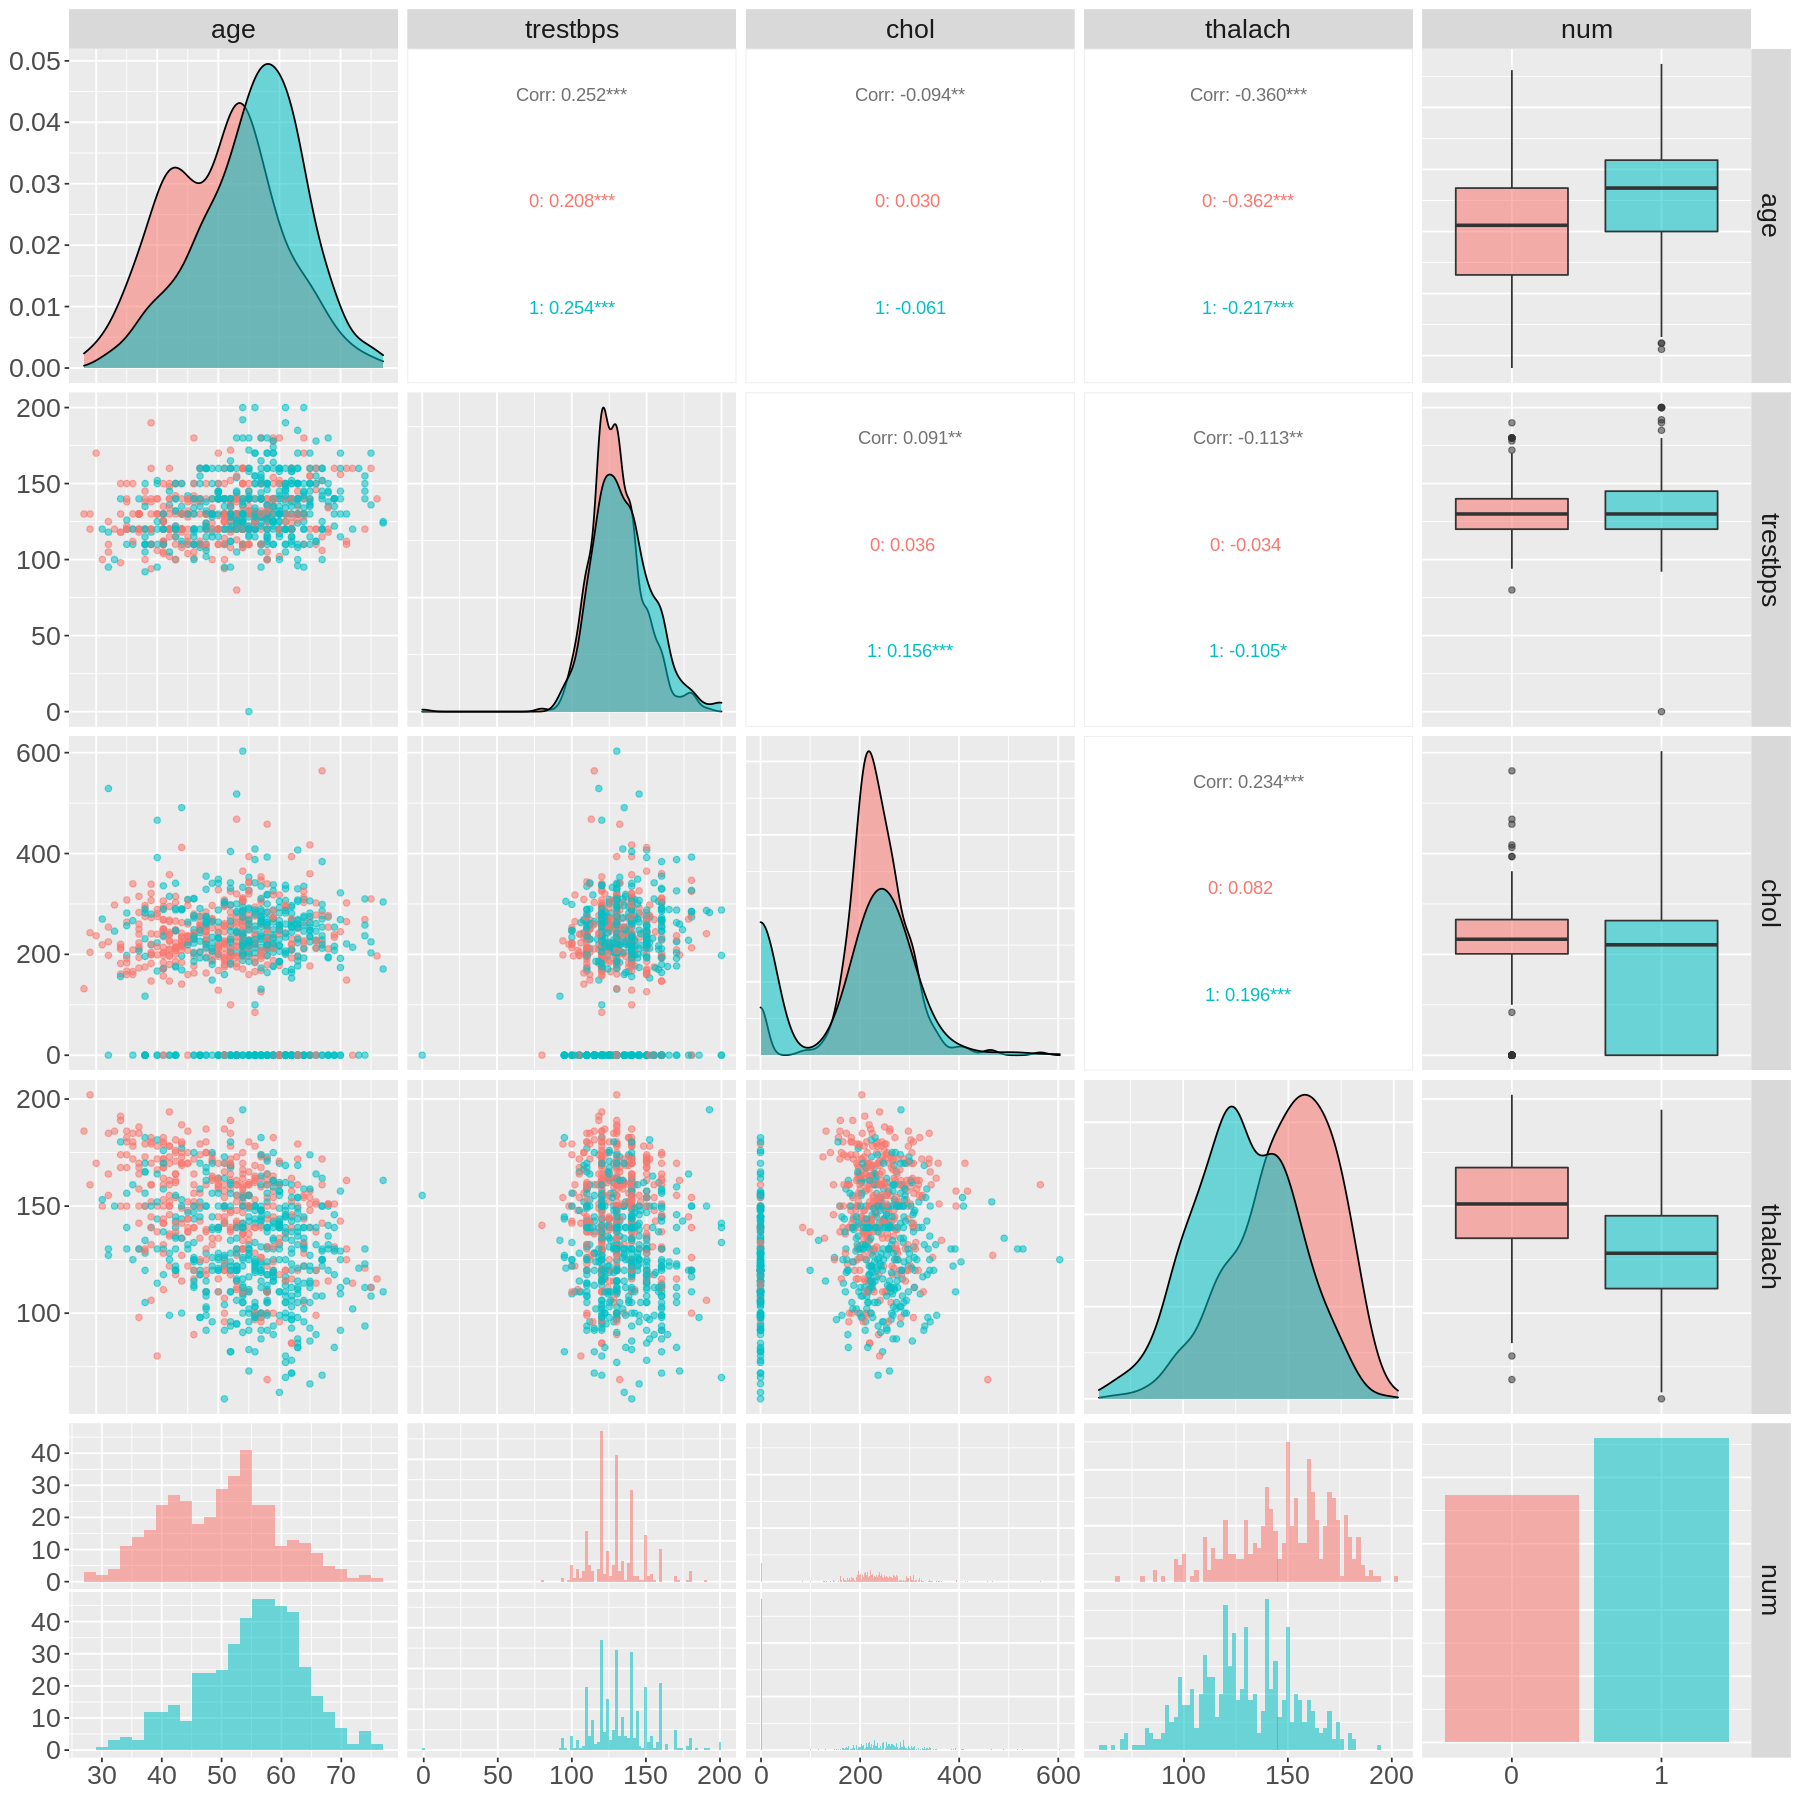

In [6]:
options(repr.plot.width = 15, repr.plot.height = 15)

covariance_plot <- data_tidy %>%
    select(age, trestbps, chol, thalach, num) %>%
    ggpairs(aes(colour = num, alpha = 0.5), lower = list(combo = wrap("facethist", binwidth = 2))) +
    theme(text = element_text(size=20)) 

strong("Figure 1: Correlation matrix between all numerical covariates, and target")
covariance_plot

The covariance plot shows that the distribution for when `chol` = 0 is skewed, which can bias our predictions and model. Thus, further investigation into categorial variables, including `chol`, has been performed using a boxplot matrix. 

Shiny tags cannot be represented in plain text (need html)

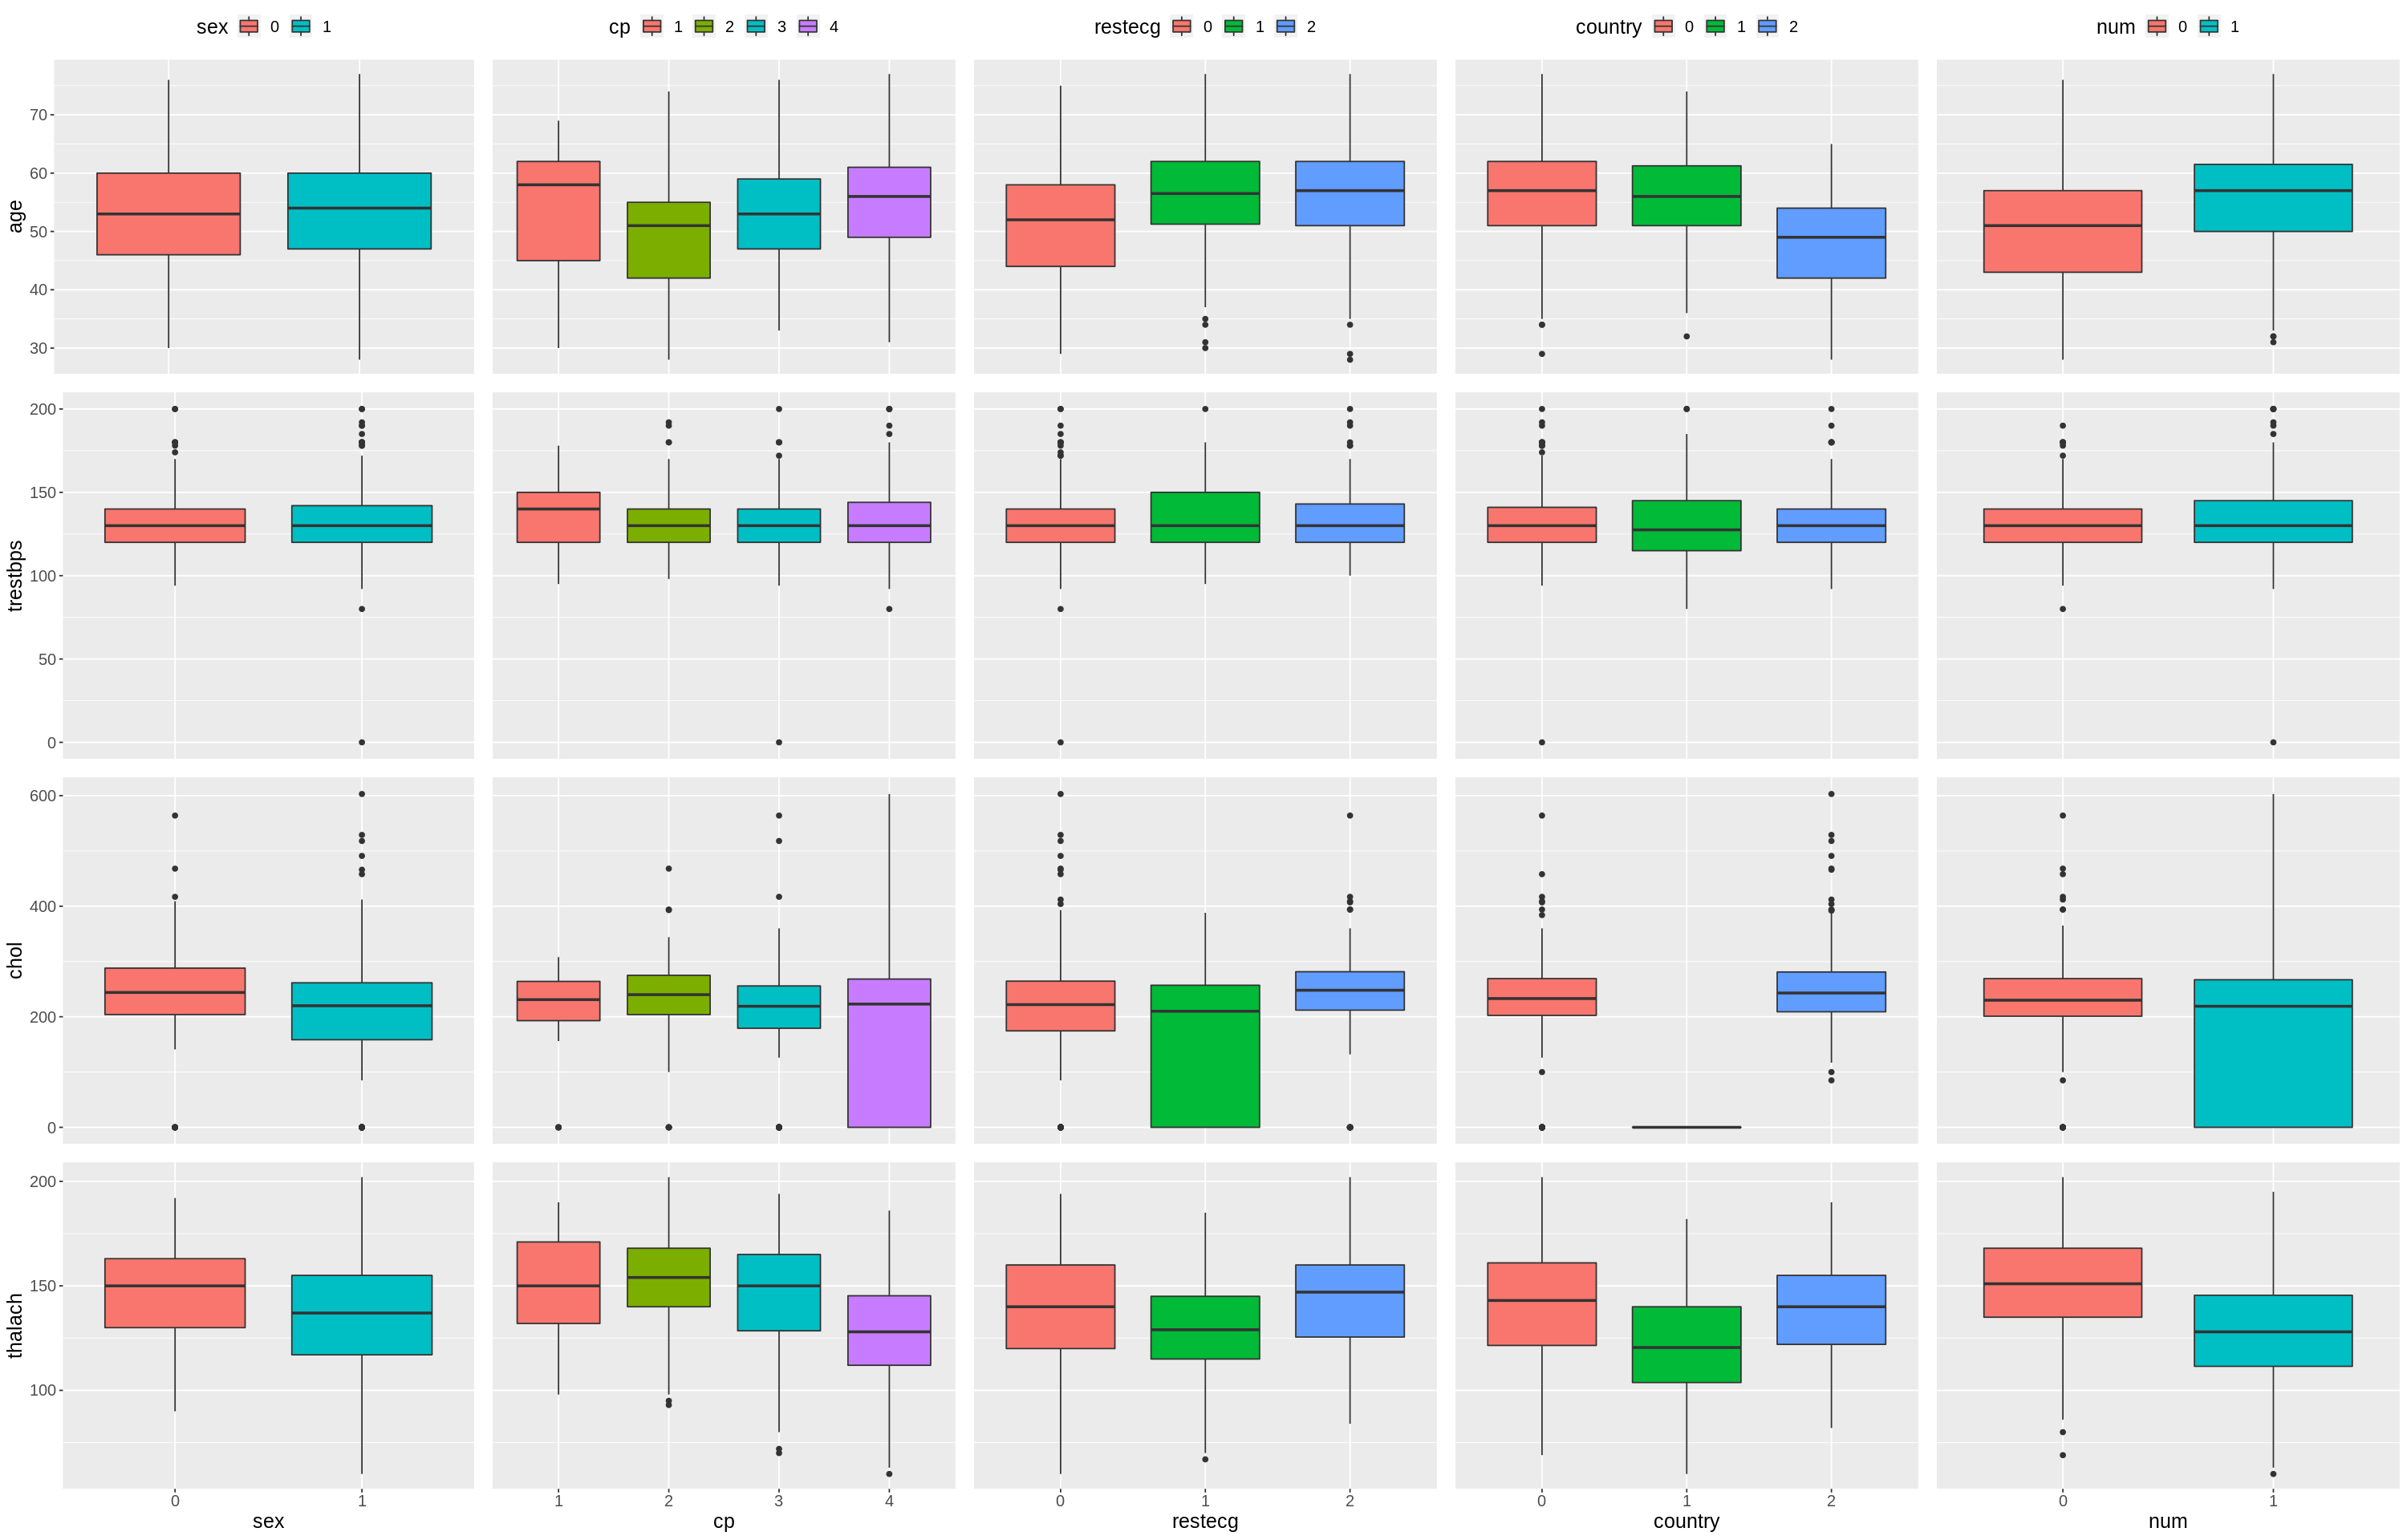

In [7]:
options(repr.plot.width = 25, repr.plot.height = 16)

numeric_variables <- colnames(select(data_tidy, where(is.numeric)))
categorical_variables <- colnames(select(data_tidy, where(is.factor)))

index <- 1

for (j in categorical_variables) {
    
    count <- 1
    for (i in numeric_variables) {
        p <- data_tidy %>% ggplot() + 
            geom_boxplot(aes(x = .data[[j]], y = .data[[i]], fill = .data[[j]])) + 
            theme(text = element_text(size=15))
        
        if (count == 1) {
            p <- p + theme(legend.position = "top")
        } else {
            p <- p + theme(legend.position = "none")
        } 
        if (index != 1) {
            p <- p + 
                theme(axis.title.y=element_blank(),
                axis.text.y=element_blank(),
                axis.ticks.y=element_blank())
        } 
        if (count != 4) {
            p <- p + 
                theme(axis.title.x=element_blank(),
                axis.text.x=element_blank(),
                axis.ticks.x=element_blank())
        } 
        
        assign(paste0("plot", toString(count)), p)
        count <- count + 1
    }
    
    g <- plot_grid(plot1, plot2, plot3, plot4, ncol = 1)
    assign(paste0("g", toString(index)), g)
    index <- index + 1
}

strong("Figure 2: Boxplot distributions of all discrete covariates")
plot_grid(g1, g2, g3, g4, g5, ncol = 5) 

In all plots with `chol`, there are many observations with `chol` = 0. Our tidy data will be prone to outliers as no form of data collection is fully robust. However, upon further inspection of the graphs above, we see that the numerous values of `chol` = 0 skew the quartiles of the boxplots. Cholesterol performs important roles in our body, such as making hormones, thus we require cholesterol<sup>3</sup>. This means that logically, it does not make sense for your body to have 0 mg/dl of cholesterol. 

Since this measurement is likely a mistake in the data collection process, and is skewing the distribution (including with  mean and standard deviation) of the variable, we removed all rows with `chol` being 0. The new summary table after removing outliers is shown below. 

In [8]:
data_tidy <- data_tidy %>% filter(chol != 0)

summary_table <- data_tidy %>%
    mutate(across(age:num, ~as.numeric(as.character(.x)))) %>%
    select(-num) %>%
    pivot_longer(cols = age:country, 
                names_to = "variable", 
                values_to = "value") %>%
    group_by(variable) %>%
    summarize(mean = mean(value), median = median(value), sd = sd(value), max = max(value), min = min(value))

strong("Table 5: Summary table for all numerical covariates (mean, median, standard deviation, max, min)")
t(summary_table)



Shiny tags cannot be represented in plain text (need html)

variable,age,chol,country,cp,restecg,sex,thalach,trestbps
mean,52.5563798,247.0816024,0.7982196,3.1691395,0.6468843,0.7403561,141.2685460,132.6839763
median,54.0,240.0,0.0,4.0,0.0,1.0,142.5,130.0
sd,9.4276283,58.6256225,0.9801582,0.9557195,0.8549814,0.4387648,24.9232520,17.7428255
max,77,603,2,4,2,1,202,200
min,28,85,0,1,0,0,69,92


### **Model selection and analysis**

With `data_tidy` now being free of abnormalities, we can begin the feature selection process and analysis. The first step is to partition the data into a training set and a testing set to evaluate our logistic regression model. 

In [9]:
# Setting seed to get reproducible training and testing sets
set.seed(1999)

split <- initial_split(data_tidy, prop = 0.75, strata = num) 
train_tidy <- training(split)
test_tidy <- testing(split)

Figure 1 and 2 provided a good idea of the distributions of each covariate against `num`, and the relevance that each variable has when predicting `num`. However, it is difficult to know which variables will be beneficial for prediction as some variables have quite uniform distributions across all values of `num`. This signifies that no matter the value of the covariate, it can fall within either of the predicted classes. Generally, this means that the variable is hard to classify and thus a poor predictor, however, getting a quantitative answer to which variables are relevant would be of great benefit. Therefore, a logistic regression model with L1 (LASSO) regularization will be implemented to encourage sparsity within the resulting coefficients. This way, the coefficients of all irrelevant variables will be 'driven' to 0, which will show us which covariates are driving the predictions of the model. Additionally, we will implement stepforward selection to compare and verify the result we get from LASSO.

In [10]:
set.seed(1999)

# Creating logistic regression object with training data
logistic_model <- glm(
    formula = num ~ .,
    data = train_tidy,
    family = binomial)

# Turning training and testing dataframes into matrices (requirement for glmnet logistic regression)
logistic_X_train <- model.matrix(object = logistic_model, data = train_tidy)[, -1]
logistic_X_test <- model.matrix(object = logistic_model, data = test_tidy)[, -1]

logistic_Y_train <- as.matrix(train_tidy$num, ncol = 1)
logistic_Y_test <- as.matrix(test_tidy$num, ncol = 1)

#### ***LASSO-Logistic regression***

Before beginning regularization, we must use cross-validation to choose a proper $\lambda$. Cross-validation gives an estimate of the test error rate, the CV misclassification rate. $\lambda$, the tuning constant associating the weight of the penalizing term $\lambda\sum|\beta|_1$, measures the amount of penalization given equally to each coefficients. Choosing $\lambda$ will determine how much focus we put onto eliminating irrelevant variables. As $\lambda$ increases, more penalization is applied and more variables will be driven to `0`.

In [11]:
set.seed(1999)

# Performing cross validation to choose the best lambda
logistic_model_cv <- cv.glmnet(
    x = logistic_X_train, 
    y = logistic_Y_train,
    alpha = 1,
    family = "binomial",
    type.measure = "class",
    nfolds = 20, 
    lambda = seq(0,0.3,0.001))

logistic_model_cv


Call:  cv.glmnet(x = logistic_X_train, y = logistic_Y_train, lambda = seq(0,      0.3, 0.001), type.measure = "class", nfolds = 20, alpha = 1,      family = "binomial") 

Measure: Misclassification Error 

    Lambda Index Measure      SE Nonzero
min  0.001   300  0.1960 0.01513      11
1se  0.028   273  0.2099 0.01637       9

<br>
We used 20-fold cross-validation to maintain a balance of saving computational power and lowering the bias. Compared to a 20-fold CV, 5-fold and 10-fold CV would be more biased and LOOCV would be very expensive computationally since we have 505 rows of data.
In the above output, $\lambda_{min}$ represents the choice of $\lambda$ with the smallest CV misclassification rate, and $\lambda_{1se}$ represents the greatest $\lambda$ such that its CV misclassification rate is within 1 standard error of the CV misclassification rate of $\lambda_{min}$.
As we can see, thes two choices of lambda have very close CV misclassification error (around 20% for both). We will plot the CV misclasification rate v.s. the $log(\lambda)$ in the figure below.

Shiny tags cannot be represented in plain text (need html)

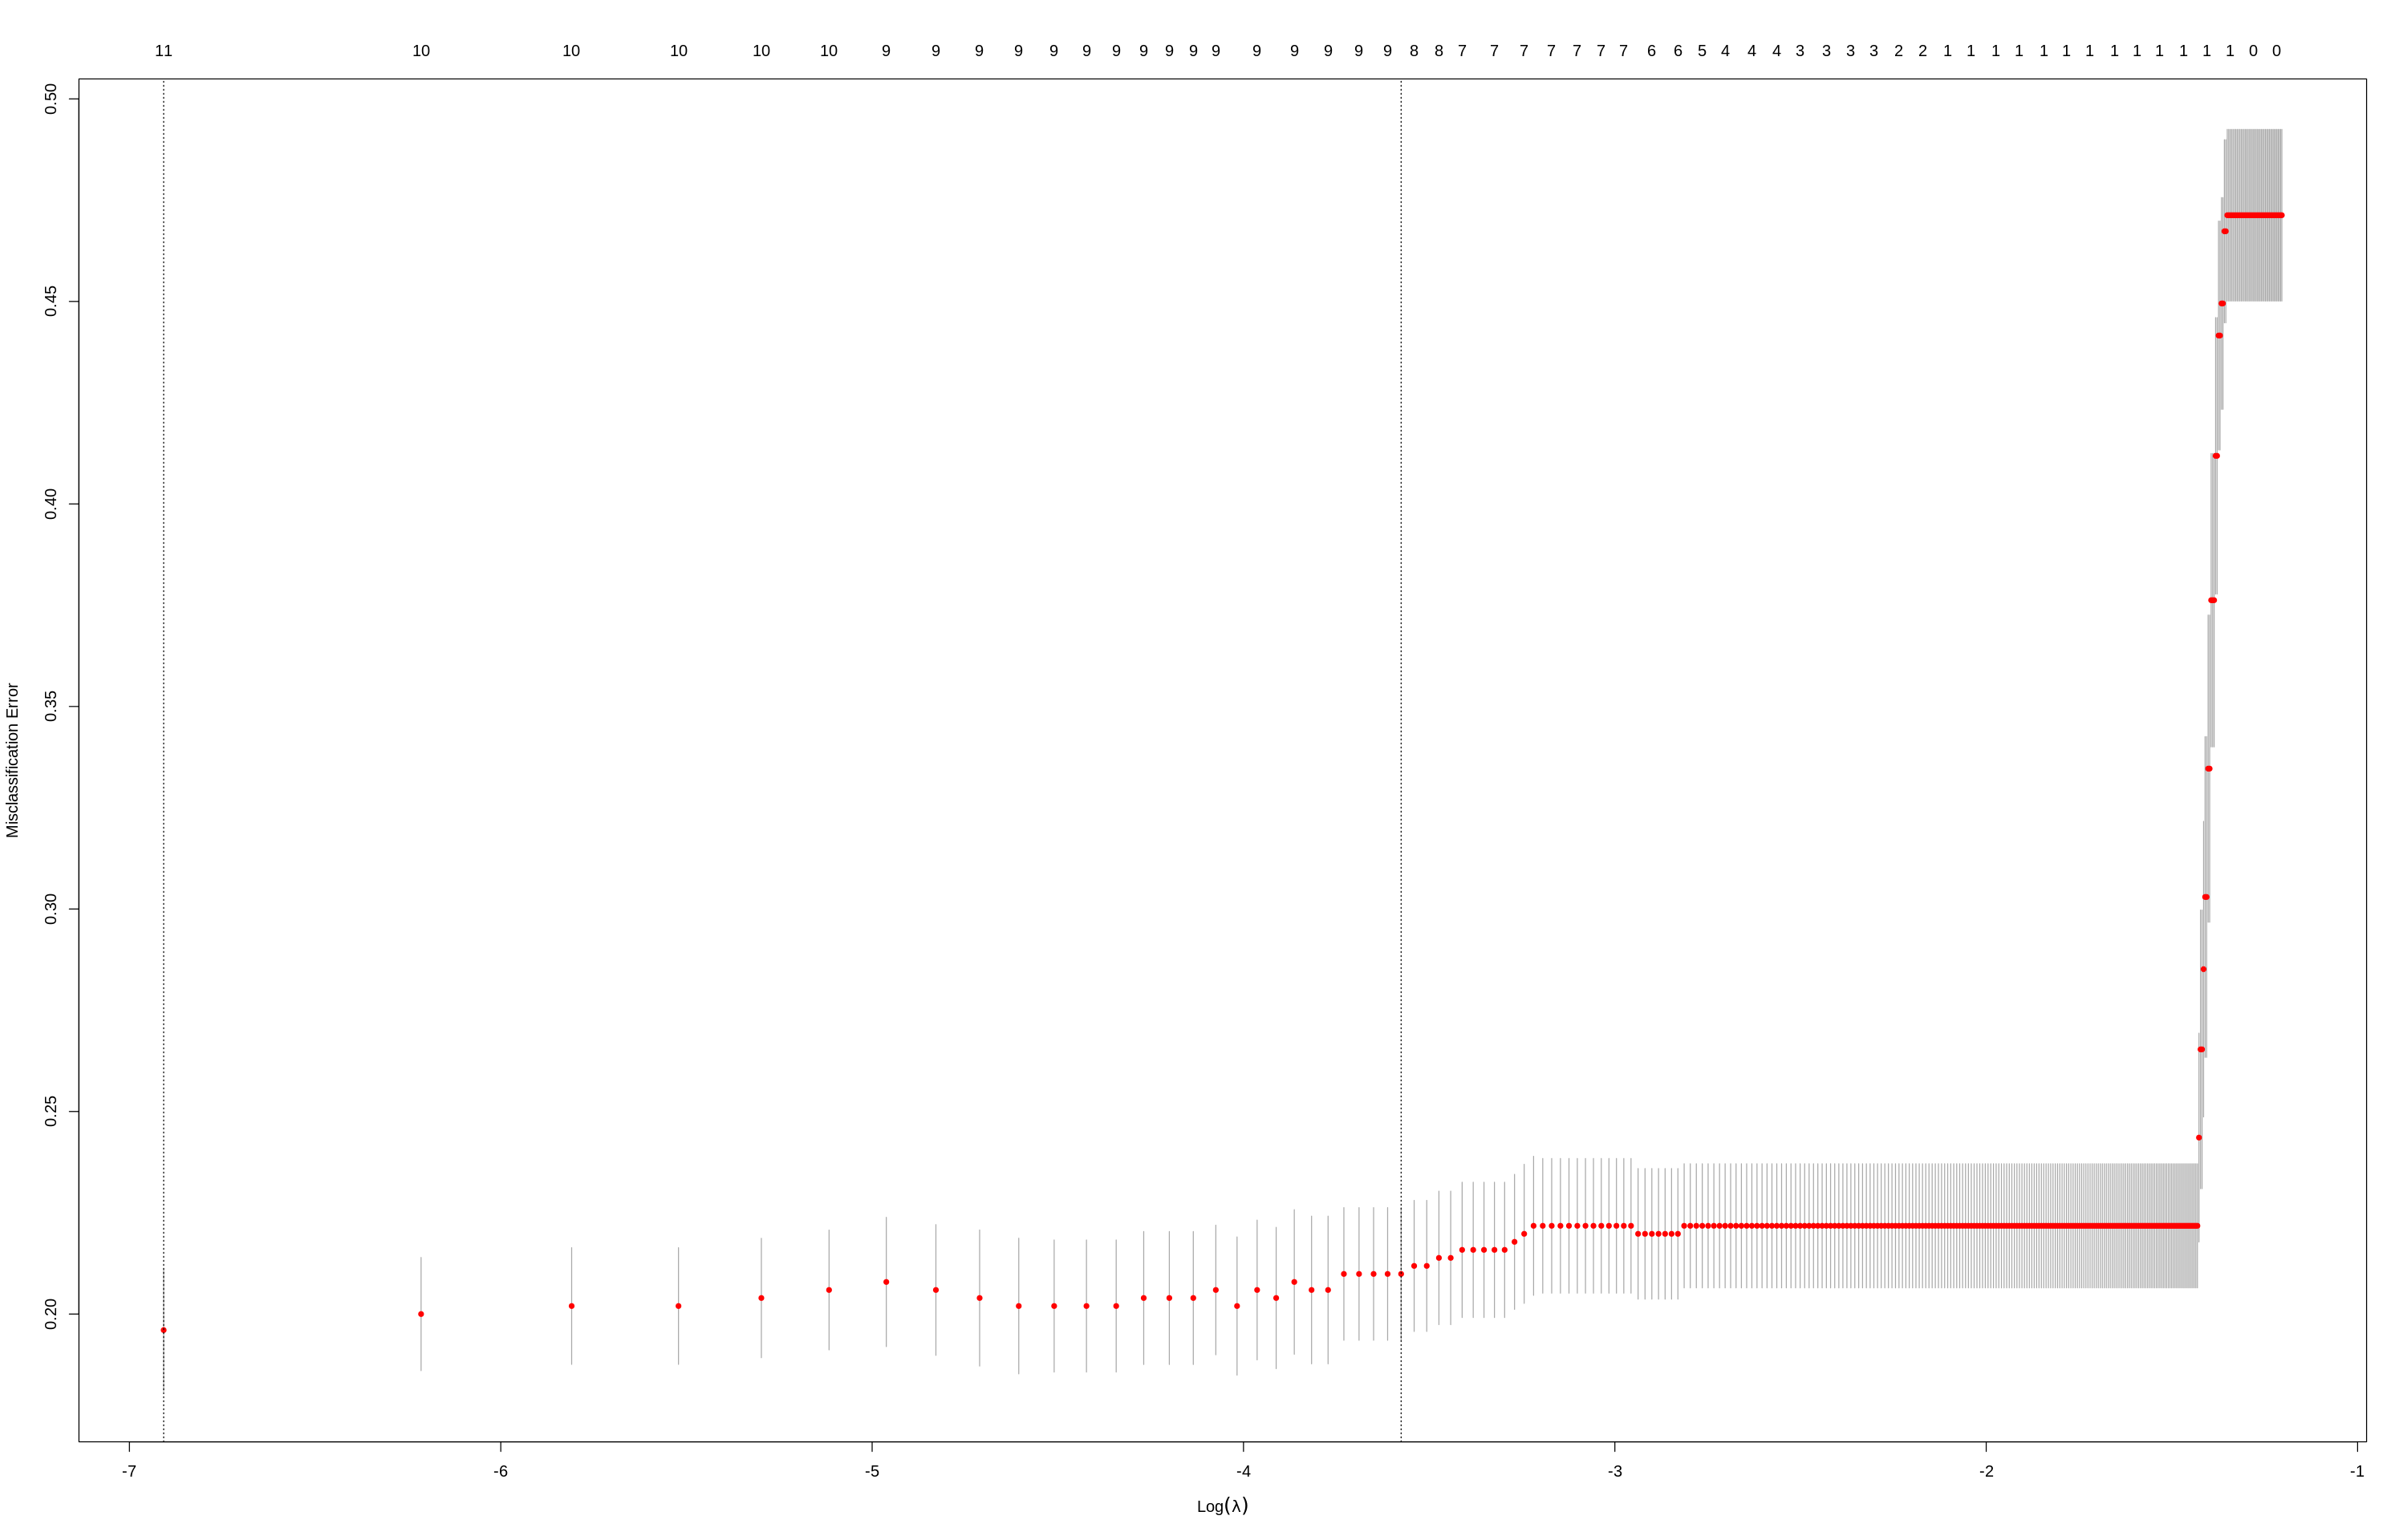

In [12]:
strong("Figure 3: CV for Logistic Regression with varying lambdas")
plot(logistic_model_cv)

At $\lambda=\lambda_{1se}=0.028$, we achieve a simpler model with minimal increase in the CV misclassification error than with $\lambda_{min}$. If we increase $\lambda$ further, the CV misclassification rate will keep increasing, diminishing the predictive power of our model. Therefore, choosing a $\lambda$ within 1 standard error of the $\lambda$ that minimizes the misclassification error is ideal, which maintains a low CV misclassification rate while eliminating two dummy variables (from `restecg`).

In [13]:
# Training the logistic regression model on the best value of lambda
regularized_logistic_model <- glmnet(
    x = logistic_X_train, 
    y = logistic_Y_train,
    alpha = 1,
    family = "binomial",
    lambda = logistic_model_cv$lambda.1se
)

coef(regularized_logistic_model)

12 x 1 sparse Matrix of class "dgCMatrix"
                      s0
(Intercept) -2.531996247
age          0.016527824
sex1         0.877500650
cp2         -0.332734646
cp3         -0.033018106
cp4          1.756068047
trestbps     0.007549846
chol         0.002183713
restecg1     .          
restecg2     .          
thalach     -0.010509968
country2    -0.049884608

In the above output, we see that `restecg` was deemed an irrelevant variable through the LASSO-regularization method. Specifically, since `restecg` had multiple internal levels, the fact that both `restecg` dummy variables were driven to 0 demonstrates that it is not useful in predicting heart disease. We can check these results through a stepforward selection algorithm which (greedily) tests almost all combinations of covariates, and returns the *classification error, sensitivity, and specificity of the training set* for each combination. 

#### ***Stepforward selection***

In [14]:
x = as.data.frame(logistic_X_train) 
y = as.data.frame(logistic_Y_train) %>% mutate(num = as.numeric(V1)) %>% select(-V1)

# This function is quite long, so the code for it is sourced from logistic_stepforward.r (written by us)
strong("Table 6: Forward selection for an unregularized logistic regression model")
forward_selection_for_logistic_model(x,y)

Shiny tags cannot be represented in plain text (need html)

,num_of_var,vars,mis_rate,sensitivity,specificity
,<chr>,<chr>,<chr>,<chr>,<chr>
1,1,cp4,0.221782178217822,0.789915966386555,0.767790262172285
2,2,cp4+age,0.221782178217822,0.789915966386555,0.767790262172285
3,3,cp4+age+sex1,0.211881188118812,0.76890756302521,0.805243445692884
4,4,cp4+age+sex1+chol,0.201980198019802,0.781512605042017,0.812734082397004
5,5,cp4+age+sex1+chol+trestbps,0.194059405940594,0.798319327731092,0.812734082397004
6,6,cp4+age+sex1+chol+trestbps+thalach,0.19009900990099,0.802521008403361,0.816479400749064
7,7,cp4+age+sex1+chol+trestbps+thalach+cp2,0.19009900990099,0.810924369747899,0.808988764044944
8,8,cp4+age+sex1+chol+trestbps+thalach+cp2+country2,0.188118811881188,0.80672268907563,0.816479400749064
9,9,cp4+age+sex1+chol+trestbps+thalach+cp2+country2+restecg2,0.184158415841584,0.815126050420168,0.816479400749064


From the stepforward selection model, we can see that the misclassification rate is lowest when we have either 8 or 9 input variables. Apart from `cp3`, this model deemed `restecg` to be an irelevant predictor since both internal dummy variables were added last to the model. More specifically, there is a negligible decrease in misclassification rate when both layers of `restecg` are added, thus signifying that the presence of `restecg` is not particularily useful in predicting heart disease. 

For these reasons, we selected all covariates except for `restecg` for our final model (since an equivalently performing model with less variables is preferred). Additionally, we used the regularized model over the non-regularized model to lower the risk of overfitting on the training data. Additionally, the regularized model suffers less from overfitting as we have used the CV misclassification rate for model selection, whereas we used the misclassification rate of the training data for the stepforward selection. Now, we can print a confusion matrix to see how the model is performing with respect to its false positives and false negatives. 

### **Model evaluation**

In [15]:
y_pred_train <- predict(regularized_logistic_model, newx = logistic_X_train, type = "response") %>% as.vector()
y_train <- logistic_Y_train %>% as.vector()

# This function was too long to implement in this notebook, so it was sourced from conf_mat_logistic.r (written by us)
strong("Table 7: Confusion matrix/statistics for a regularized logistic model (with default cutoff = 0.5)")
conf_mat_logistic(true_y = y_train, pred_y = y_pred_train, display = TRUE)

Shiny tags cannot be represented in plain text (need html)

             Pred True Pred False
Actual True        189         49
Actual False        55        212

Accuracy: 0.7940594 
Sensitivity: 0.7941176 
Specificity: 0.7940075 


,Pred True,Pred False
Actual True,189,49
Actual False,55,212


Although the accuracy of this model is respectable (~80%), it is actually not the most important statistic that we must consider. Given the context of this data, it is extremely important that we minimize false negatives. If this model is deployed, false negatives would mean that a patient who actually has heart disease is not detected through the model. This is far more dangerous than false positives, as a false positive would be inconvenient, whereas a false negative could lead to possibly fatal implications. Therefore, now that we have found the best model with respect to its raw predictive power, we can use this model and subsequently change the threshold of prediction to lower the number of false negatives (i.e. increase the sensitivity of the model). 

Below is a plot that depicts the relationship between the threshold of prediction, sensitivity (defined as $\frac{TP}{TP+FN}$ ), and raw classification accuracy. In our case, getting the sensitivity as close to 1 as possible would be ideal. However, that is not inherently feasible as that would return a cutoff of 0. Therefore, we must find a good balance between sensitivity and the threshold of prediction.

Shiny tags cannot be represented in plain text (need html)

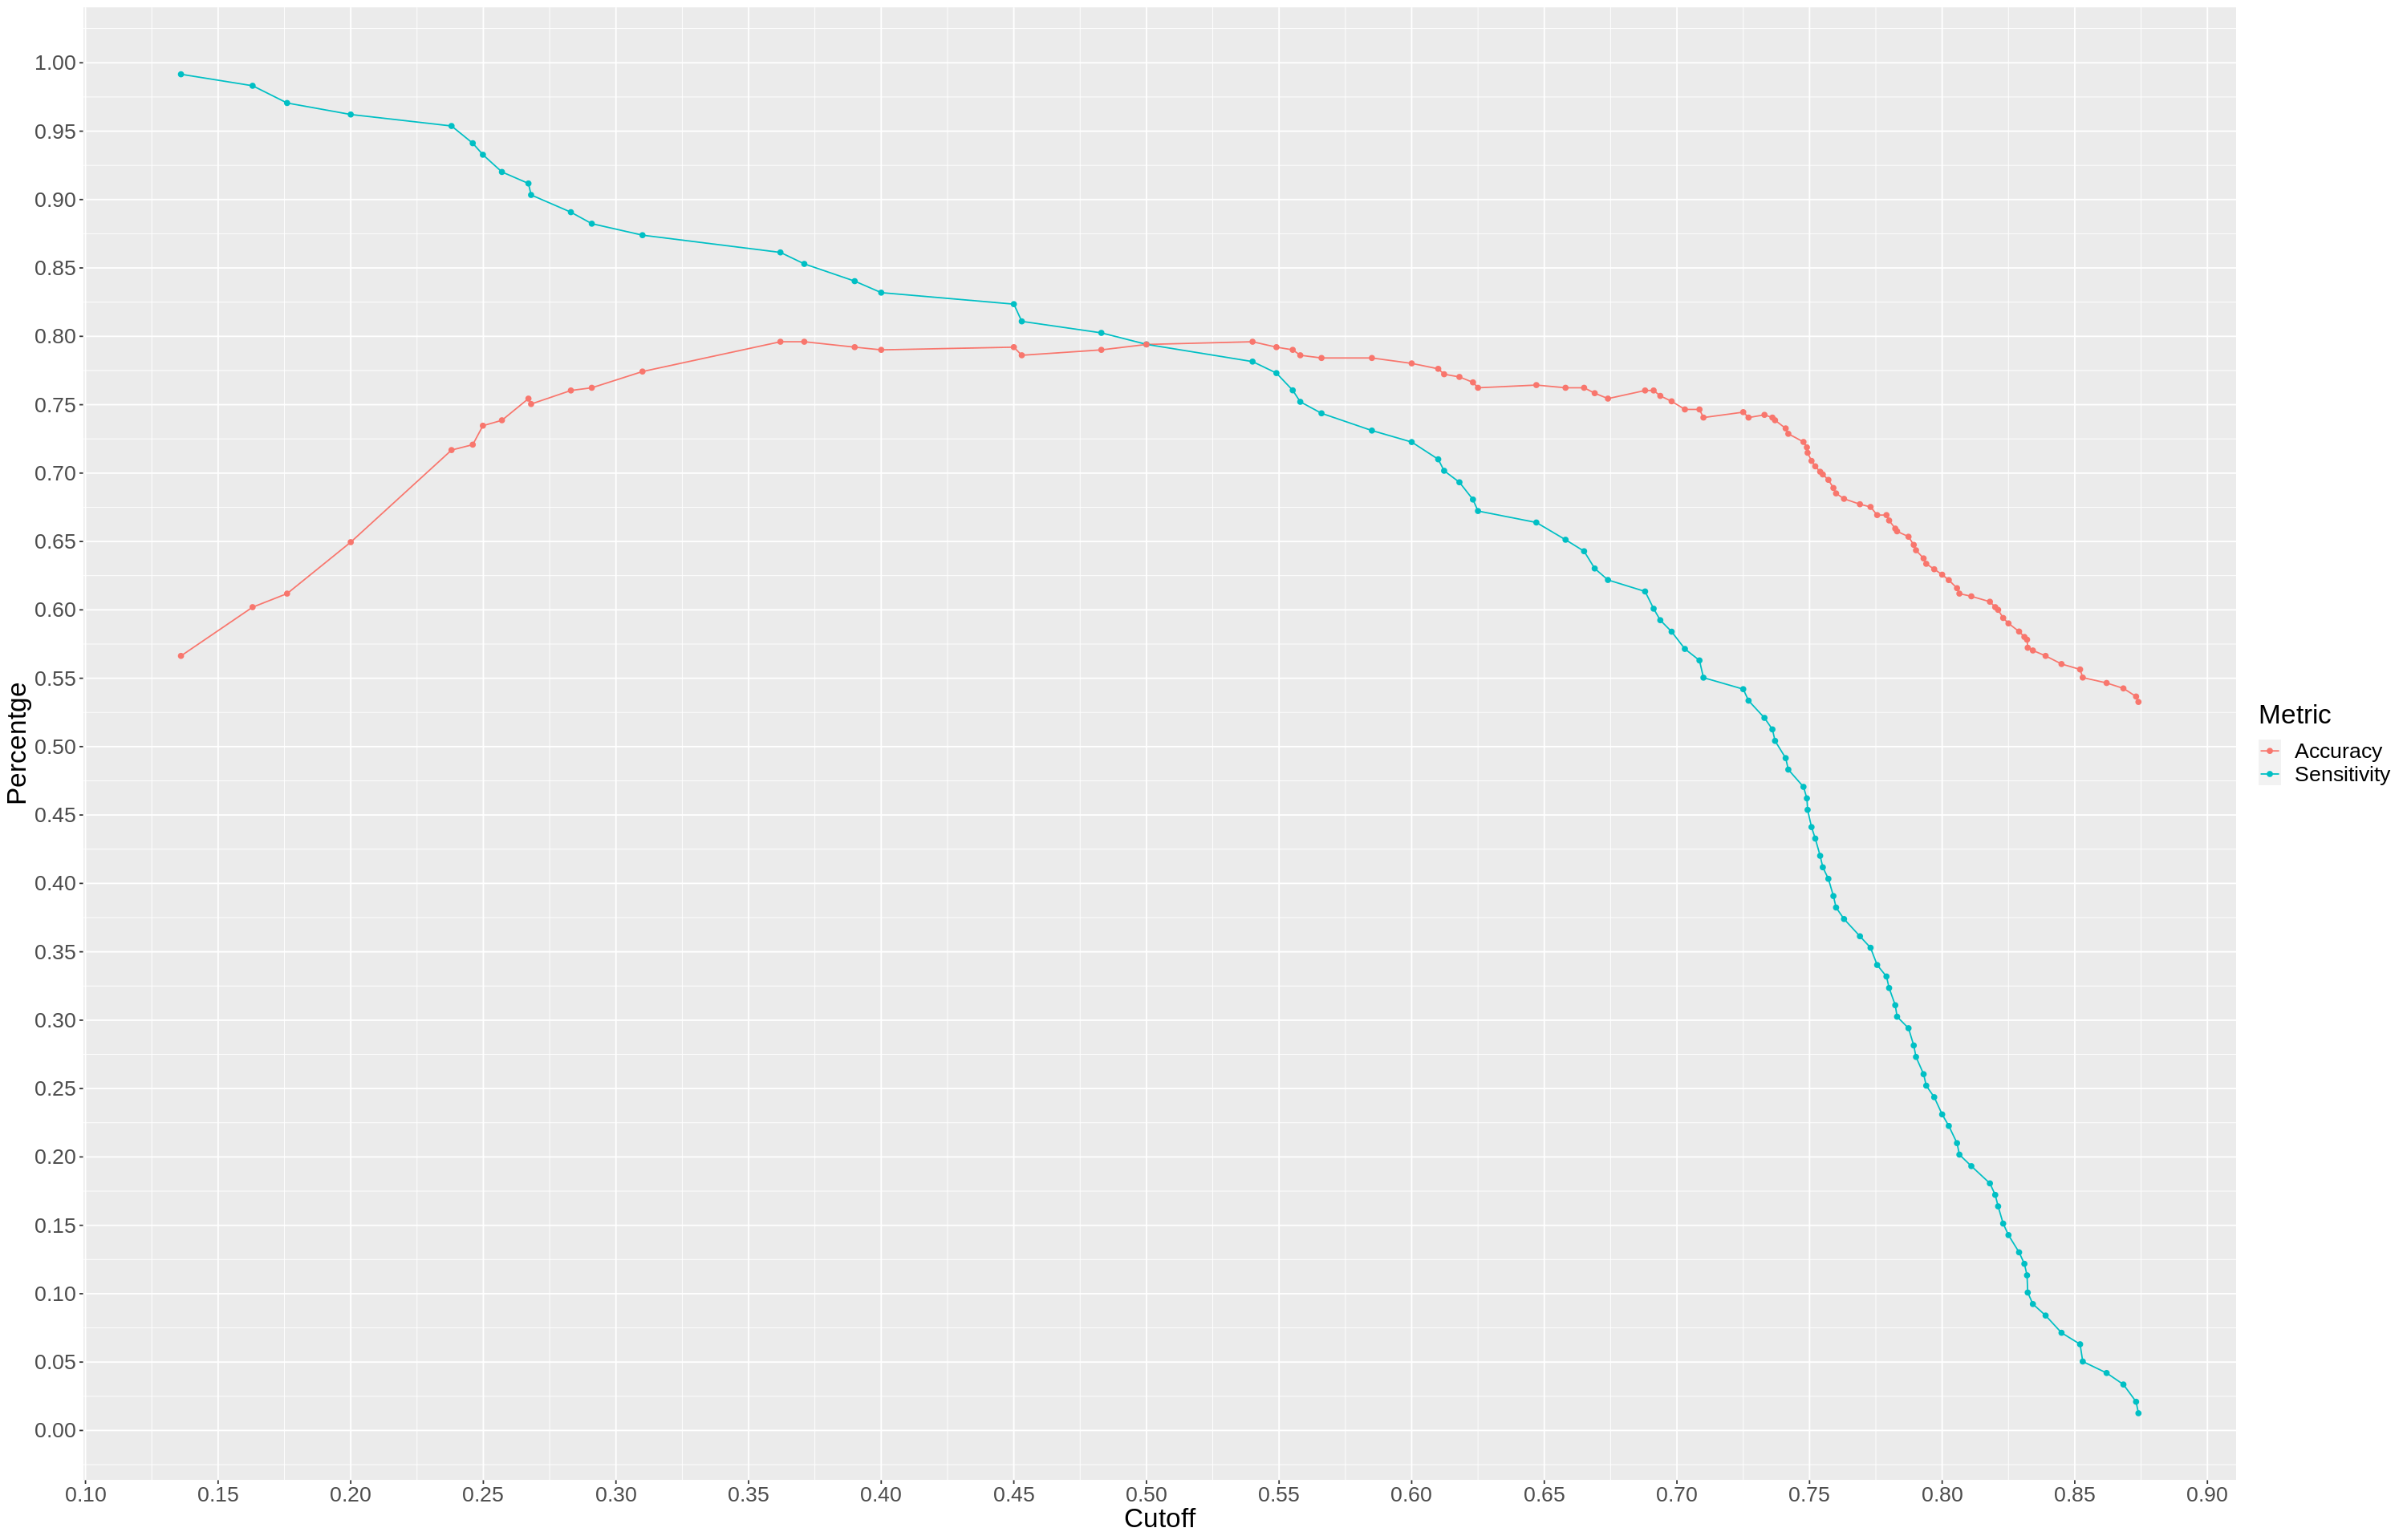

In [16]:
# Iterating through many possible cutoff values and calculating the sensitivity and accuracy at each
count <- 1
result <- data.frame(Cutoff = logical(0), Sensitivity = logical(0), Specificity = logical(0), Accuracy = logical(0))

for (i in seq(0.01, 0.99, by = 0.01)) {
    row <- logistic_model_sens(pred_y = y_pred_train, true_y = y_train, sensitivity = i)
    result[count,] <- row
    count <- count + 1
}

# Creating the plot to optimize sensitivity and accuracy
threshold_plot <- result %>%
    select(-Specificity) %>%
    pivot_longer(cols = Sensitivity:Accuracy, 
            names_to = "variable", 
            values_to = "value") %>%
    ggplot(aes(x = Cutoff, y = value, color = variable)) +
    geom_line() +
    geom_point() +
    labs(y = "Percentge", colour = "Metric") + 
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = seq(0,1,0.05)) +
    scale_y_continuous(breaks = seq(0,1,0.05))

strong("Figure 4: Relationship between prediction cutoff and accuracy/sensitivity")
threshold_plot

From the plot above, we can see that right around 0.238, there is an "elbow" shape on the sensitivity curve. This is the optimal threshold where we can properly balance sensitivity and raw classification accuracy because decreasing the cutoff any more than this will result in a drastic decrease in accuracy but an insignificant increase in sensitivity. With the threshold value that optimizes both the sensitivity and the raw classification rate, we can create a new confusion matrix which has been updated to be less prone to false negatives.

In [17]:
optimal_cutoff <- 0.238

strong("Table 8: Confusion matrix/statistics for a regularized logistic model (with optimized cutoff = 0.238)")
conf_mat_logistic(true_y = y_train, pred_y = y_pred_train, display = TRUE, cutoff = optimal_cutoff)

Shiny tags cannot be represented in plain text (need html)

             Pred True Pred False
Actual True        227         11
Actual False       132        135

Accuracy: 0.7168317 
Sensitivity: 0.9537815 
Specificity: 0.505618 


,Pred True,Pred False
Actual True,227,11
Actual False,132,135


### **Model performance**

Finally, with both the optimal model and threshold, we can test the performance of this model against the testing data. This will allow us to get an idea of how our model will perform in the real world. 

In [18]:
y_pred_test <- predict(regularized_logistic_model, newx = logistic_X_test, type = "response") %>% as.vector()
y_test <- logistic_Y_test %>% as.vector()

strong("Table 9: Confusion matrix/statistics for a regularized logistic model on the testing data (with optimized cutoff = 0.238)")
conf_mat_logistic(true_y = y_test, pred_y = y_pred_test, display = TRUE, cutoff = optimal_cutoff)

Shiny tags cannot be represented in plain text (need html)

             Pred True Pred False
Actual True         78          2
Actual False        37         52

Accuracy: 0.7692308 
Sensitivity: 0.975 
Specificity: 0.5842697 


,Pred True,Pred False
Actual True,78,2
Actual False,37,52


Applying our final model on the testing set produces a final accuracy of 76.9%, and a final sensitivity of 97.5%.

**Note:** We created a function called `logistic_model_sens` in the `log_model_spec.r` file that accepts a logistic model (non-regularized) as input, or the true and predicted values of any binary classification model. This function allows the user to specify any sensitivity or specificity value (for the model), and returns a prediction threshold value for that binary classifier.  

**Note**: You can find the source code for all of the functions that we have created (`conf_mat_logistic.r`, `log_model_spec.r`, and `logistic_stepforward.r`) by following this Github link: https://github.com/erosrojas/Analyzing-Heart-Disease

# Discussion

### **Findings**

Our goal was to predict whether patients had heart disease or not. In the feature selection process, we implemented the logistic regression model using LASSO and stepforward selection. Both methods demonstrated that `restecg` is not useful in predicting heart disease in patients. For this reason, we used all the covariates except for `restecg` in our final model. When applying our model that optimizes the sensitivity and the misclassification rate to our testing data, we produced a final accuracy of 76.9% and  sensitivity of 97.5% for predicting heart disease.

Our model has an overall good performance in predicting heart disease for all suspected patients. While using our testing data, the sensitivity rate overwhelms other metrics because it is highly important that heart disease can be diagnosed when a patient suffers from it. Our accuracy and specificity is lower than the sensitivity as they are metrics that we deemed to be less important in our case. 

We did not have expectations about our findings as we did not make hypotheses about our predictive model. Based on our Preliminary Data Analysis, we believed that `chol` might not be used as one of the covariates in our final model. But, it seems that instead `restecg` was excluded. At the beginning of the project, we wanted to achieve high accuracy as that is often an indicator of predictive power in a model. However, we later prioritized sensitivity as that statistic held more importance in our research question. 

### **Implications**

Our findings have some significant implications. Instead of accuracy, the most significant indicator for our model was sensitivity, the ability to detect false negatives.

Comparing false negatives and false positives, the false negative would lead to more serious consequences. Undetected and untreated heart disease would eventually kill the patient. We achieved a very high level of sensitivity in our model, which means that applying this model in real life, like in a hospital, would minimize a lot of incorrect fatal diagnoses for heart disease. Long term, this would ensure that most people with heart disease would be identified, treated, and would live longer.

A false positive could also potentially lead to serious consequences. A person who is incorrectly diagnosed with heart disease may have to take prescription drugs for a long time, which can damage their liver and other organs, and worsen their health when they are actually healthy. Therefore, the consequences of a false positive should not be taken lightly, but a false negative leads to deadly consequences. 

### **Improvements**

One useful improvement for our model would be the ability to predict the severity of heart disease in a patient instead of only providing a binary response (either you have heart disease or not). This would help to create more personalized treatment for patients and truly understand the progression of the disease. 

### **Future Questions** 

- Would our model be able to predict heart disease with this much accuracy and sensitivity in patients from countries around the world? 
- How accurate of a model could be made for predicting the severity of heart disease in patients? 
- Could a similar model to ours be applied to different heart conditions other than heart disease, or even different health conditions? 
- Is sensitivity always the most important indicator when creating models predicting diagnosis for health conditions? 
- How expensive would it be to implement a predictive model similar to ours in the health care sector? 
- How would predictive models like ours influence how doctors and patients interact and how much burden would it remove from the healthcare sector? 

# References 

<sup>1</sup> Abdar, M., Książek, W., Acharya, U. R., Tan, R.-S., Makarenkov, V., & Pławiak, P. (2019). A new machine learning technique for an accurate diagnosis of coronary artery disease. Computer Methods and Programs in Biomedicine, 179, 104992. https://doi.org/10.1016/j.cmpb.2019.104992

<sup>2</sup> Akella, A., & Akella, S. (2021). Machine learning algorithms for predicting coronary artery disease: efforts toward an open source solution. Future Science OA, 7(6), FSO698. https://doi.org/10.2144/fsoa-2020-0206

<sup>3</sup> CDC. (2021, January 26). Cholesterol Myths and Facts. Centers for Disease Control and Prevention. https://www.cdc.gov/cholesterol/myths_facts.htm

‌
<sup>4</sup> Centers for Disease Control and Prevention. (2020). Heart disease in the United States
https://www.cdc.gov/heartdisease/facts.htm  

<sup>5</sup> Mayo Clinic. (2021, February 9). Heart disease - Symptoms and causes. Mayo Clinic. https://www.mayoclinic.org/diseases-conditions/heart-disease/symptoms-causes/syc-20353118

<sup>6</sup> Muhammad, L. J., Al-Shourbaji, I., Haruna, A. A., Mohammed, I. A., Ahmad, A., & Jibrin, M. B. (2021). Machine Learning Predictive Models for Coronary Artery Disease. SN Computer Science, 2(5). https://doi.org/10.1007/s42979-021-00731-4

<sup>7</sup> Shah, D., Patel, S., & Bharti, S. K. (2020). Heart Disease Prediction using Machine Learning Techniques. International Journal of Innovative Technology and Exploring Engineering, 9(5), 1456–1460. https://doi.org/10.35940/ijitee.e2862.039520

<sup>8</sup> UCI Machine Learning Repository: Heart Disease Data Set. (2019). Uci.edu. https://archive.ics.uci.edu/ml/datasets/Heart+Disease 

<sup>9</sup> Verma, L., Srivastava, S., & Negi, P. C. (2016). A Hybrid Data Mining Model to Predict Coronary Artery Disease Cases Using Non-Invasive Clinical Data. Journal of Medical Systems, 40(7). https://doi.org/10.1007/s10916-016-0536-z

<sup>10</sup> Wang, C., Zhao, Y., Jin, B., Gan, X., Liang, B., Xiang, Y., Zhang, X., Lu, Z., & Zheng, F. (2021). Development and Validation of a Predictive Model for Coronary Artery Disease Using Machine Learning. Frontiers in Cardiovascular Medicine, 8. https://doi.org/10.3389/fcvm.2021.614204

‌<sup>11</sup> World Health Organization. (2021, June 11). Cardiovascular Diseases (CVDs). Who.int; World Health Organization: WHO. https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)

# Appendices

## **Appendix I**

**Table 10**: Dataset variable names, types, and descriptions

<div> <img src="https://raw.githubusercontent.com/erosrojas/Analyzing-Heart-Disease/main/Variable_table.png" width="1000"/> </div>

<!-- ![Table 1: Dataset variable names, types, and descriptions](Variable_table.png) -->